In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, mean_absolute_percentage_error
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
import pmdarima as pm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

# Load dataset

In [ ]:
url = "/content/streamflow_filled.csv"
df = pd.read_csv(url)

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").sort_index()
df = df[["Q (m3/s)"]].rename(columns={"Q (m3/s)": "Q_m3_s"})
print(df.head(), df.shape)


            Q_m3_s
Date              
1967-01-01  2690.0
1967-01-02  2650.0
1967-01-03  2650.0
1967-01-04  2610.0
1967-01-05  2570.0 (18628, 1)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18628 entries, 1967-01-01 to 2017-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Q_m3_s  18628 non-null  float64
dtypes: float64(1)
memory usage: 291.1 KB


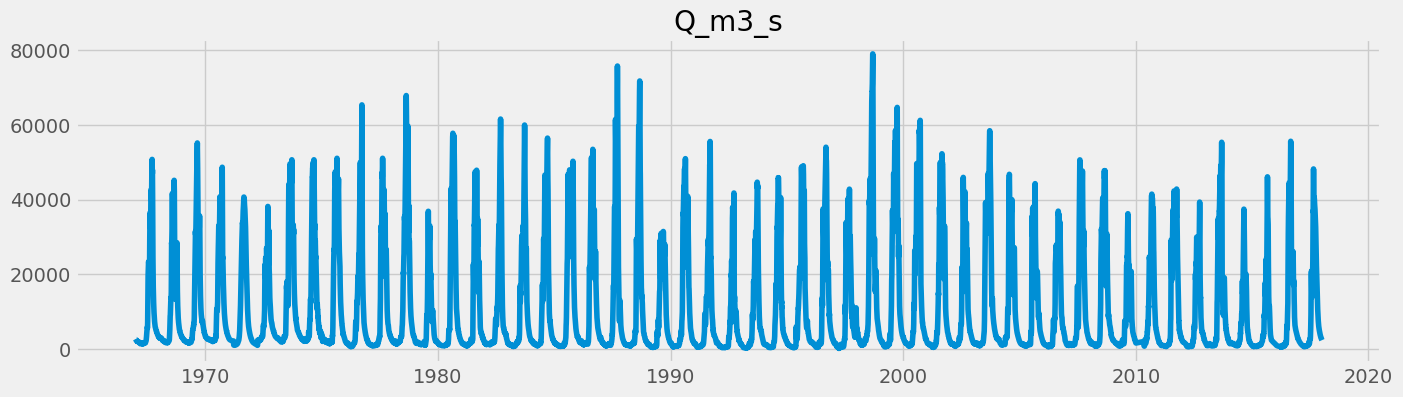

In [ ]:
df.info()

plt.figure(figsize=(15,4))
plt.plot(df.index, df["Q_m3_s"])
plt.title("Q_m3_s")
plt.show()

# SARIMA Model

## Setting Up Monthly Datasets

In [ ]:
df_month_avg = df.resample('ME').agg({
    'Q_m3_s': 'mean'
})

## Plotting Datasets


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 612 entries, 1967-01-31 to 2017-12-31
Freq: ME
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Q_m3_s  612 non-null    float64
dtypes: float64(1)
memory usage: 9.6 KB


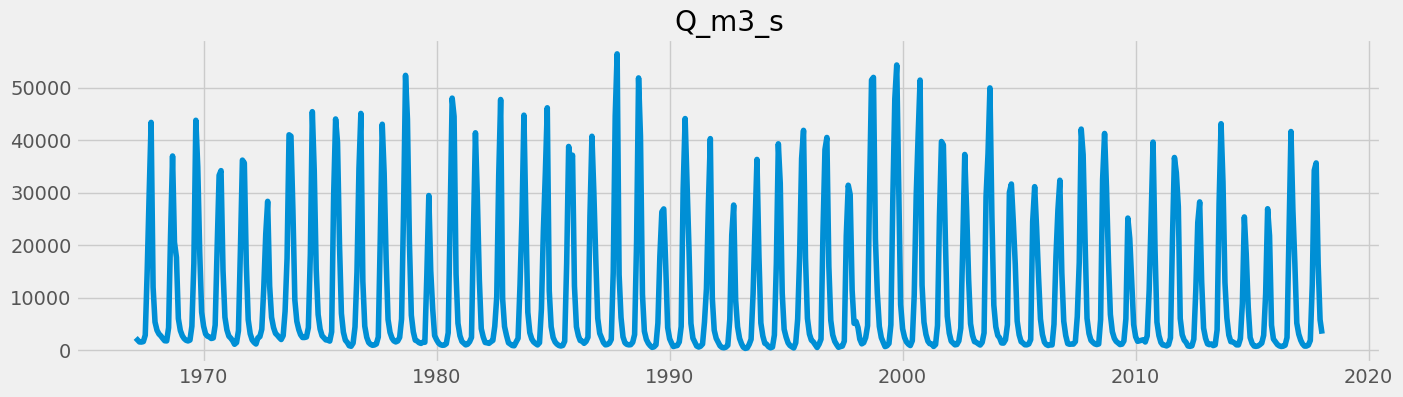

In [ ]:
df_month_avg.info()

plt.figure(figsize=(15,4))
plt.plot(df_month_avg.index, df_month_avg["Q_m3_s"])
plt.title("Q_m3_s")
plt.show()

## Seasonal Decomposition


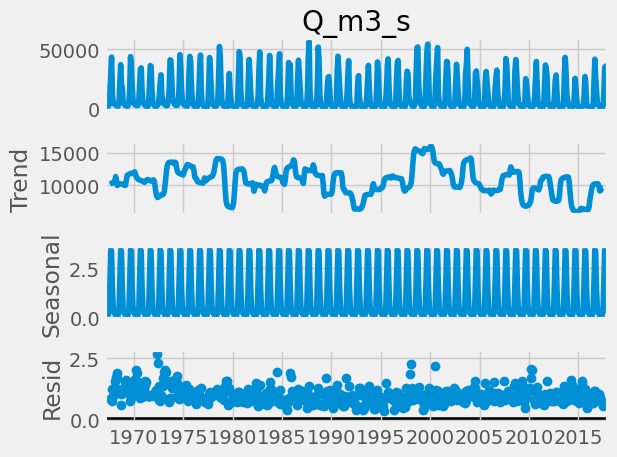

In [ ]:
decomp = seasonal_decompose(df_month_avg["Q_m3_s"], model="multiplicative", period=12)
decomp.plot()
plt.show()

## ACF/PACF


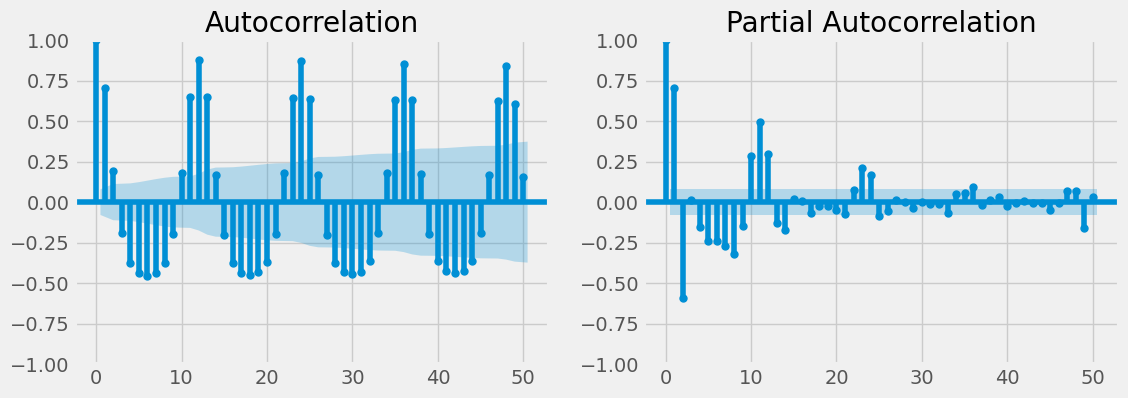

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(df_month_avg["Q_m3_s"], ax=ax[0], lags=50)
plot_pacf(df_month_avg["Q_m3_s"], ax=ax[1], lags=50, method="ywm")
plt.show()

## Splitting Train/Test


In [ ]:
test_h = 24
avg_train = df_month_avg.iloc[:-test_h]
avg_test = df_month_avg.iloc[-test_h:]

## Auto ARIMA


In [ ]:
avg_auto_arima = pm.auto_arima(avg_train['Q_m3_s'], m=12)
avg_order = avg_auto_arima.order
avg_sorder = avg_auto_arima.seasonal_order

## Fit Model


In [ ]:
def fit_forecast(ts_train, steps, order, seasonal_order=None, exog_train=None, exog_test=None):
    mod = SARIMAX(ts_train, order=order,
                  seasonal_order=seasonal_order,
                  exog=exog_train,
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit(disp=False)
    fc = mod.forecast(steps=steps, exog=exog_test)
    return mod, fc

In [ ]:
avg_model, avgfc = fit_forecast(avg_train['Q_m3_s'],test_h, avg_order, avg_sorder)

## Plot Forecasts


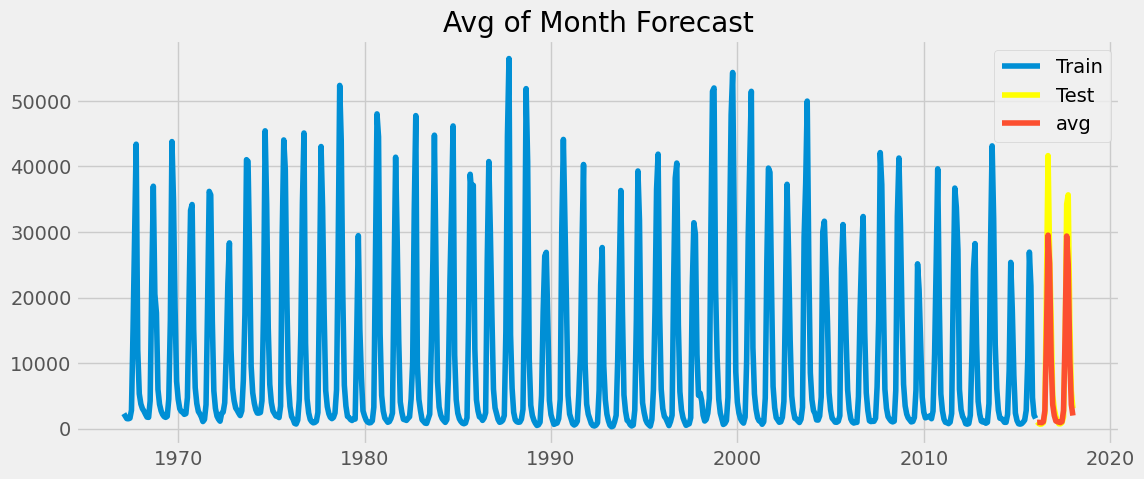

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(avg_train.index, avg_train["Q_m3_s"], label="Train")
plt.plot(avg_test.index, avg_test["Q_m3_s"], label="Test", color="yellow")
plt.plot(avg_test.index, avgfc, label="avg")
plt.title("Avg of Month Forecast")
plt.legend()
plt.show()

## Metrics

In [ ]:
def metric(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = mean_absolute_percentage_error(actual, pred)*100
    return rmse, mae, mape

In [ ]:

res = {}
for name, m, fc in [
    ("Avg", avg_model, avgfc)
]:
    rmse, mae, mape = metric(avg_test["Q_m3_s"], fc)
    res[name] = {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "AIC": m.aic,
        "BIC": m.bic
    }

print(pd.DataFrame(res))

               Avg
RMSE   4175.435523
MAE    2453.494988
MAPE     26.218991
AIC   11772.425043
BIC   11789.842523


# Machine learning Study


# Feature engineering

In [ ]:
df['Date'] = df.index.day
df['lag_1'] = df['Q_m3_s'].shift(1)
df['lag_2'] = df['Q_m3_s'].shift(2)
df['rolling_mean_3'] = df['Q_m3_s'].rolling(window=3).mean()
df['target_class'] = (df['Q_m3_s'].shift(-1) > df['Q_m3_s']).astype(int)  # classification label: “will the value go up in the next time step?”

In [ ]:
df.dropna(inplace=True)

# Features and targets

In [ ]:
features = ['Date', 'lag_1', 'lag_2', 'rolling_mean_3']
X = df[features]
y_reg = df['Q_m3_s']
y_clf = df['target_class']

In [ ]:
X.head()

,Date,lag_1,lag_2,rolling_mean_3
Date,,,,
1967-01-03,3,2650.0,2690.0,2663.333333
1967-01-04,4,2650.0,2650.0,2636.666667
1967-01-05,5,2610.0,2650.0,2610.000000
1967-01-06,6,2570.0,2610.0,2570.000000
1967-01-07,7,2530.0,2570.0,2543.333333


# Time-aware train-test split (80/20)

In [ ]:
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_reg_train, y_reg_test = y_reg[:split_idx], y_reg[split_idx:]
y_clf_train, y_clf_test = y_clf[:split_idx], y_clf[split_idx:]

# Store results

In [ ]:
results = {}

# Regression Models

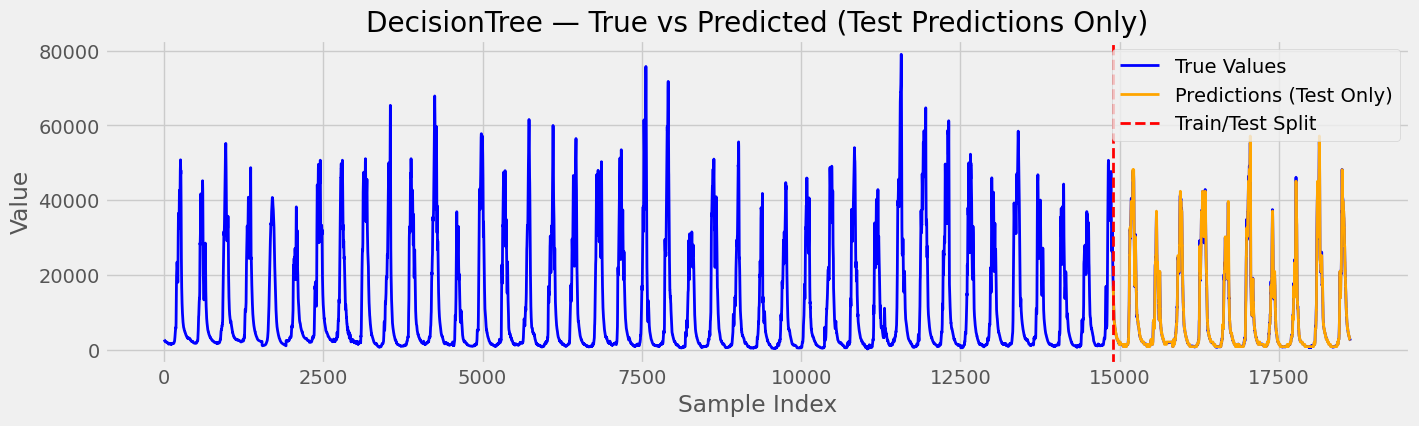

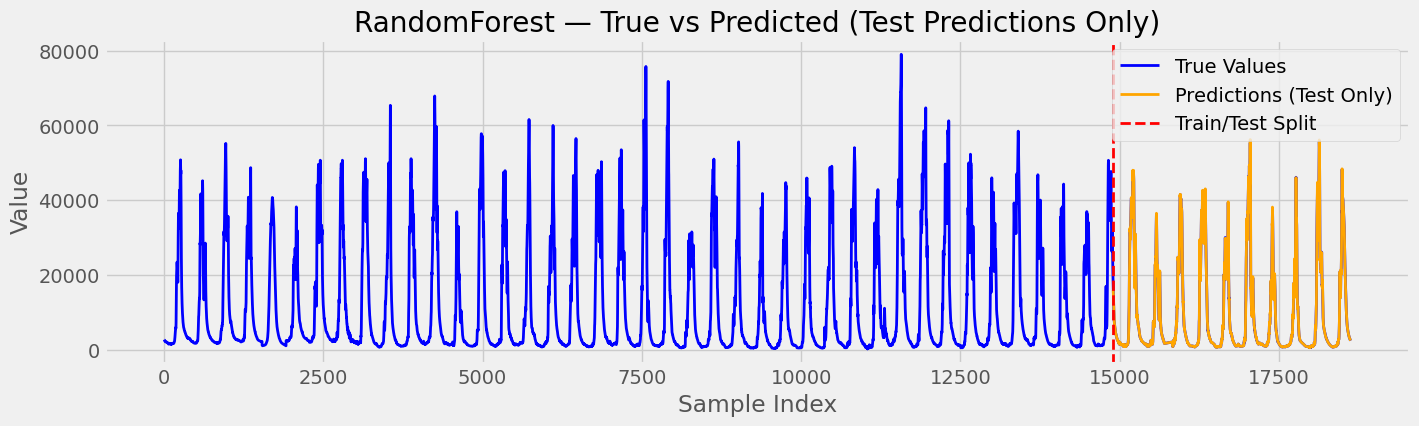

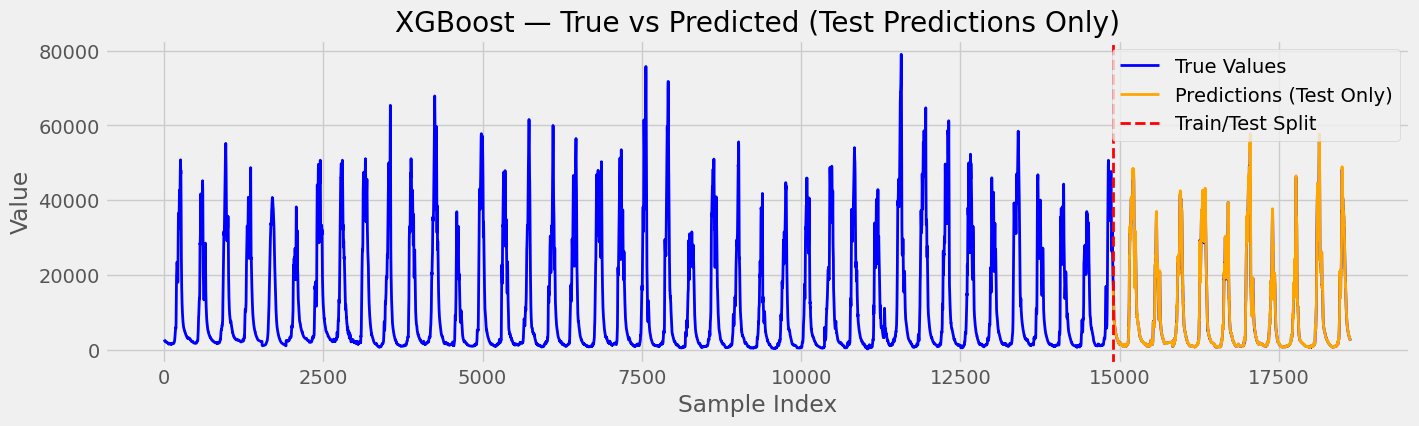

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

models_reg = {
    'DecisionTree': DecisionTreeRegressor(max_depth=5),
    'RandomForest': RandomForestRegressor(n_estimators=100),
    'XGBoost': xgb.XGBRegressor(),
}

import matplotlib.pyplot as plt
import numpy as np

for name, model in models_reg.items():

    model.fit(X_train, y_reg_train)

    preds_test = model.predict(X_test)

    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_reg_test, preds_test)),
        "MAE": mean_absolute_error(y_reg_test, preds_test),
        "R2": r2_score(y_reg_test, preds_test),
        "MAPE": mean_absolute_percentage_error(y_reg_test, preds_test)*100
    }

    full_true = np.concatenate([y_reg_train, y_reg_test])
    train_len = len(y_reg_train)

    x_full = np.arange(len(full_true))
    x_test = np.arange(train_len, train_len + len(preds_test))

    plt.figure(figsize=(15,4))

    plt.plot(x_full, full_true, label="True Values", color="blue", linewidth=2)

    plt.plot(x_test, preds_test, label="Predictions (Test Only)", color="orange", linewidth=2)

    plt.axvline(train_len, color="red", linestyle="--", linewidth=2, label="Train/Test Split")

    plt.title(f"{name} — True vs Predicted (Test Predictions Only)")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()



# Classification Models

In [ ]:
models_clf = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SVM': SVC()
}

class_results = {}
for name, model in models_clf.items():
    model.fit(X_train, y_clf_train)
    preds = model.predict(X_test)
    class_results[name] = {
        "Accuracy": accuracy_score(y_clf_test, preds),
        "Report": classification_report(y_clf_test, preds, output_dict=True),
        "ConfusionMatrix": confusion_matrix(y_clf_test, preds)
    }

results["Classification"] = class_results

In [ ]:
regression_results = pd.DataFrame({k: v for k, v in results.items() if k != "Classification"}).T
regression_results = regression_results.sort_values(by="RMSE")
print("\n Regression Model Comparison:")
print(regression_results)

classification_data = {
    name: {
        "Accuracy": round(metrics["Accuracy"], 3),
        "Precision (1)": round(metrics["Report"]["1"]["precision"], 3),
        "Recall (1)": round(metrics["Report"]["1"]["recall"], 3),
        "F1-score (1)": round(metrics["Report"]["1"]["f1-score"], 3)
    }
    for name, metrics in results["Classification"].items()
}

classification_results = pd.DataFrame(classification_data).T
classification_results = classification_results.sort_values(by="Accuracy", ascending=False)
print("\n Classification Model Comparison:")
print(classification_results)




 Regression Model Comparison:
                    RMSE         MAE        R2      MAPE
RandomForest  257.455944   91.635574  0.999565  0.982409
XGBoost       301.699033  145.572327  0.999402  1.965715
DecisionTree  850.283818  468.088304  0.995252  8.822154

 Classification Model Comparison:
                        Accuracy  Precision (1)  Recall (1)  F1-score (1)
LogisticRegression         0.769          0.912       0.379         0.535
RandomForestClassifier     0.758          0.688       0.573         0.625
SVM                        0.724          0.825       0.273         0.411


In [ ]:
best_reg = regression_results.sort_values(by="RMSE").index[0]
best_reg_rmse = regression_results.loc[best_reg, 'RMSE']


best_clf = classification_results.sort_values(by="Accuracy", ascending=False).index[0]
best_clf_acc = classification_results.loc[best_clf, 'Accuracy']


print("\n Best Performing Models:")
print(f"- Regression: {best_reg} (Lowest RMSE = {best_reg_rmse:.2f})")
print(f"- Classification: {best_clf} (Highest Accuracy = {best_clf_acc:.2f})")


 Best Performing Models:
- Regression: LinearRegression (Lowest RMSE = 0.00)
- Classification: LogisticRegression (Highest Accuracy = 0.77)


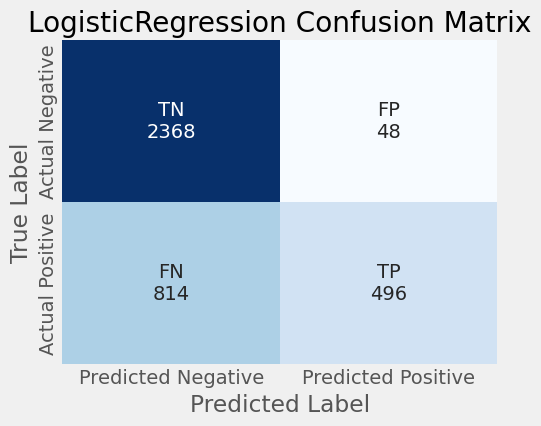

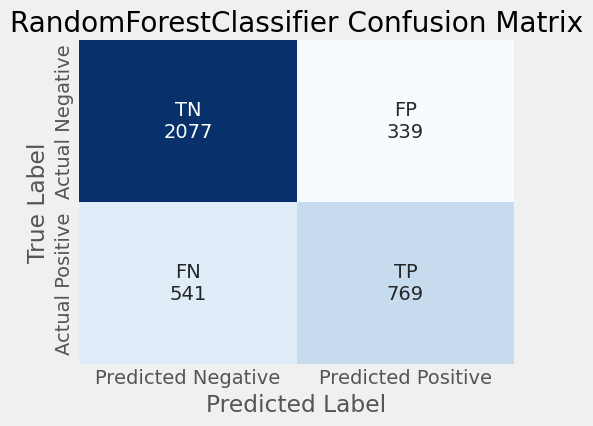

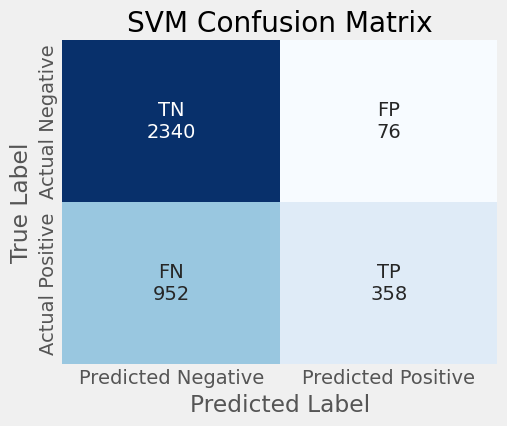

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for name, metrics in class_results.items():
    cm = metrics["ConfusionMatrix"]
    tn, fp, fn, tp = cm.ravel()

    labeled_cm = [
        [f"TN\n{tn}", f"FP\n{fp}"],
        [f"FN\n{fn}", f"TP\n{tp}"]
    ]

    plt.figure(figsize=(5, 4))
    sns.heatmap([[tn, fp], [fn, tp]], annot=labeled_cm, fmt="", cmap="Blues", cbar=False,
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"])
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
